# Lesson 18 & 19 Neural Networks For Regression

Neural networks or a biomimicry concept based on the brain. 
The brain uses neurons to determine "activation" states. 
If an activation state is reached in one neuron, information is passed to the next neuron. 
Neural networks look to copy this model.  

<img src="neural_node.png" width="500">

Each neuron has a **biased input**, $x_0$ with value 1. 
Neuron **weights** ($\vec{w}_i$) are the <mark> model parameters </mark>.

The output is obatined by applying some **activation function $g(x)$**:
$$y_{output} = \hat{y} = f(x, w) = g\left( \sum_{i=0}^{I} w_i x_i\right)$$  

## Feed-Forward Networks  

Feedforward networks are organized as layers where each layer is **fully connected** to the next. They are directed acyclic graphs. 

- **Perceptron:** Single layer neural networks (perceptron): an input layer ->  output layer
- **MLP / Multilayer Neural Networks** Input layer -> hidden layers, output layer. 

<mark> Some notes: </mark>  
- The input layer has as many units are there are inputs in the problem. 
- The output layer has as many units as are needed for the problem. 
- Each hidden layer has multiple units (possibly a different number per layer). 
- Input of each unit are all the outputs of the units of the previous layer. 

<img src="multilayer_neural_network.png" width="300"> 

## Data  
We will work with the energy data used previously to predict the power consumption based on several features. This data is a <mark> time-series</mark> dataset. We can check "Lesson 16 - Support Vector Machines for Regression" for the initial notes on the dataset. We don't need to repeat that here.  

There are 19735 datapoints and  28 features + 1 output = 29. The output is the energy consumption column. This is represented in the 'Appliances' column.  

Remember, since this is time series data, we will not do the traditional train-test-splitting we do for non-transient data. We can split it at a specific timepoint.  We will use this <mark> Time-series window </mark> approach. This creates a matrix of repetitive, broken-up chunks of data we use to separate our output information. This approach will produce a 3D matrix, because it splits according to: time and space. We only have 1 output, so this will be redundant

<img src="sliding_window.png" width="300">  

<mark> It is important  to normalize our data </mark> in this approach.  



# Multilayer Perceptron Neural Network

- MLP utilizes a supervised learning technique called back-propagation (calculus / diffeq based). 
- Except for input nodes, each node we have is a neuran that uses a **nonlinear activation function**.  
- <mark> it can distinguish data that is not linearly separable </mark>  
- <mark> MLP is a deep learning approach </mark>

This mode receives multiple hyperparameters:   
(these are stored in "params". Array values correspond to no. hidden layers.)  
- `hidden_layer_sizes`: Number of hidden layers.
- `activation`: Activation function. String values identifying predetermined functions. This may include "RELU", "logistic", etc...
- `alpha`: Magnitude of coefficient of $L2$ loss function. 
- `momentum`: Similar to physics momentum. Update direction resists change when momentum is in effect. This has the effect of <mark> overshooting local minima</mark> because they are too shallow to stop a minimization algorithm unless a sufficiently low minima exists. IE <mark> only deep enough minima </mark> will stop this training momentum. 
- `learning_rate_init`: Step size control for weight updates. 
- `n_iter_no_change`: No. Iterations allowed during training while score is not improving. 
- `learning_rate`: Scheme for updating learning rate started by `learning_rate_init`. **Constant**: does not change from initial. **invscaling**: gradually decrease learning rate at each timestep using inverse scaling exponent. **adaptive**: keeps learning rate constant to `learning_rate_init` as long as training loss keeps decreasing. Once two consecutive epocs fail to decrease training loss by at least the tolerance of the optimization, or fails to increase validation score by at least tol if `early_stopping` is enabled, the current learning rate is cut by 5 (20%).

\begin{align}
    \text{RELU (rectified linear unit)} : \ \ f(x) = max(0, x) \\[0.5ex]
    \text{Logistic (sigmoid function)} : \ \ f(x) = 1 / (1 + exp(-x))
\end{align}   

**note:** this learning_rate business is similar to an "adaptive timestep" scheme in CFD.  

<mark> To solve </mark> we will use **BayesSearch cross validation**. 

We can see from the search that MLP does well these top two parameter conclusions. 
<img src="mlp_bayessearchcv_results.png" width="600">

# Performance Evaluation  

<mark> Mean Squared Error, Mean Absolute Error </mark>  
{'mean_squared_error': 0.0034332885703717746,  
 'mean_absolute_error': 0.025398654681933128}  

 We can see the MSE is consistent with the mean test score.  

<mark> Plot Results </mark>  
We can see that this MLP neural network approach does well with this time-series approached.  
 <img src="multilayer_perceptron_neural_network_plot_result.png" width="500">


# < START >

# Imports

In [56]:
%cd ..

/Users/jaimemerizalde/Desktop/Library


In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

from Library import data

from numpy.lib.stride_tricks import sliding_window_view
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from skopt import BayesSearchCV


# Get Data

In [ ]:
filename = "Datasets/Energy.csv"
df = data.get_data(filename, index_col=[0])

Index(['date', 'Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',
       'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8',
       'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
       'Visibility', 'Tdewpoint', 'rv1', 'rv2'],
      dtype='object')

## EDA

In [14]:
df.shape
df.columns
df.describe(include="all")

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
count,19735,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,...,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
unique,19735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,11-01-2016 17:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,...,19.485828,41.552401,7.412580,755.522602,79.750418,4.039752,38.330834,3.760995,24.988033,24.988033
std,NaN,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,...,2.014712,4.151497,5.318464,7.399441,14.901088,2.451221,11.794719,4.195248,14.496634,14.496634
min,NaN,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,...,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322
25%,NaN,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,...,18.000000,38.500000,3.670000,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889
50%,NaN,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,...,19.390000,40.900000,6.920000,756.100000,83.666667,3.666667,40.000000,3.430000,24.897653,24.897653
75%,NaN,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,...,20.600000,44.338095,10.400000,760.933333,91.666667,5.500000,40.000000,6.570000,37.583769,37.583769


# Partition Data Set / Train-Test-Split DataSet

In [61]:
from numpy.lib.stride_tricks import sliding_window_view
from sklearn.preprocessing import MinMaxScaler

# Output Data
energy = df.loc[:, "Appliances"]
energy

# Split Output Data
e_train, e_test = energy.iloc[:12000], energy.iloc[12000:]

# Data Scale
scaler = MinMaxScaler()
e_train_scaled = scaler.fit_transform(e_train.to_numpy().reshape(-1, 1))
e_test_scaled = scaler.transform(e_test.to_numpy().reshape(-1, 1))

# Sliding Window
## 4 predictors for 1 output in this case. 
## This will produce a window of shape 11996 x 1 x 5, which we don't need one column of.
## That is why we use the squee method, to reduce this unnecessary complexity.
## The last value in our sliding window is what we will consider the test value, and the
## ones that came before our our training values.
w = 4
## Train
window_train = sliding_window_view(e_train_scaled, w + 1, axis=0)
window_train = window_train.squeeze()
X_train_w = window_train[:, :-1]
y_train_w = window_train[:, -1]

## Test
window_test = sliding_window_view(e_test_scaled, w + 1, axis=0)
window_test = window_test.squeeze()
X_test_w = window_test[:,:-1]
y_test_w = window_test[:,-1]

## Input data /parameters is split later during application of BayesSearch Cross Validation.


# Multilayer Perceptron Neural Network

In [ ]:
from sklearn.neural_network import MLPRegressor
from skopt import BayesSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

params = {
    "hidden_layer_sizes": [100, 200, 300], 
    "activation": ["relu", "logistic"], 
    "alpha": [0.0001, 0.001, 0.01], # L2
    "momentum": [0.95, 0.90, 0.85], # local minima momentum 
    "learning_rate_init": [0.001, 0.01, 0.1], #step-size control for weight updates.
    "n_iter_no_change": [30, 40, 50],  # No. Iterations allowed during training while score is not improving. 
    "learning_rate": ["constant", "invscaling", "adaptive"], # scheme for changing the learning rate started by `learning_rate_init`
}

mlp = MLPRegressor(max_iter=100000, early_stopping=True, random_state=0)
mlp_bs = BayesSearchCV(
    mlp, params,
    cv = TimeSeriesSplit(n_splits=5, gap=w + 1), 
    scoring=make_scorer(mean_squared_error, greater_is_better=False),
    n_iter=15, n_jobs=-1, refit=True, random_state=0, 
)
mlp_bs.fit(X_train_w, y_train_w)

with open("multilayer_perceptron_nerual_network_fit.pkl", "wb") as file:
    pickle.dump(mlp_bs, file)


In [80]:
# Visualize  
df_html = pd.DataFrame(mlp_bs.cv_results_)
df_html = df_html.loc[:,["params", "mean_test_score", "rank_test_score"]]
show_html(df_html.sort_values(by="rank_test_score").head().to_html())

,params,mean_test_score,rank_test_score
8,"{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': 300, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'momentum': 0.9, 'n_iter_no_change': 40}",-0.003727,1
11,"{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': 300, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'momentum': 0.95, 'n_iter_no_change': 40}",-0.003727,1
9,"{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'momentum': 0.85, 'n_iter_no_change': 50}",-0.003736,3
1,"{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': 300, 'learning_rate': 'invscaling', 'learning_rate_init': 0.001, 'momentum': 0.95, 'n_iter_no_change': 50}",-0.003751,4
4,"{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': 300, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'momentum': 0.95, 'n_iter_no_change': 30}",-0.003790,5


# Performance Evaluation

In [91]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error  

y_pred = mlp_bs.predict(X_test_w)
performance_stats = {
    "mean_squared_error": mean_squared_error(y_test_w, y_pred),
    "mean_absolute_error": mean_absolute_error(y_test_w, y_pred)
}
performance_stats

{'mean_squared_error': 0.0034332885703717746,
 'mean_absolute_error': 0.025398654681933128}

# Plot: Prediction VS Actual Values  

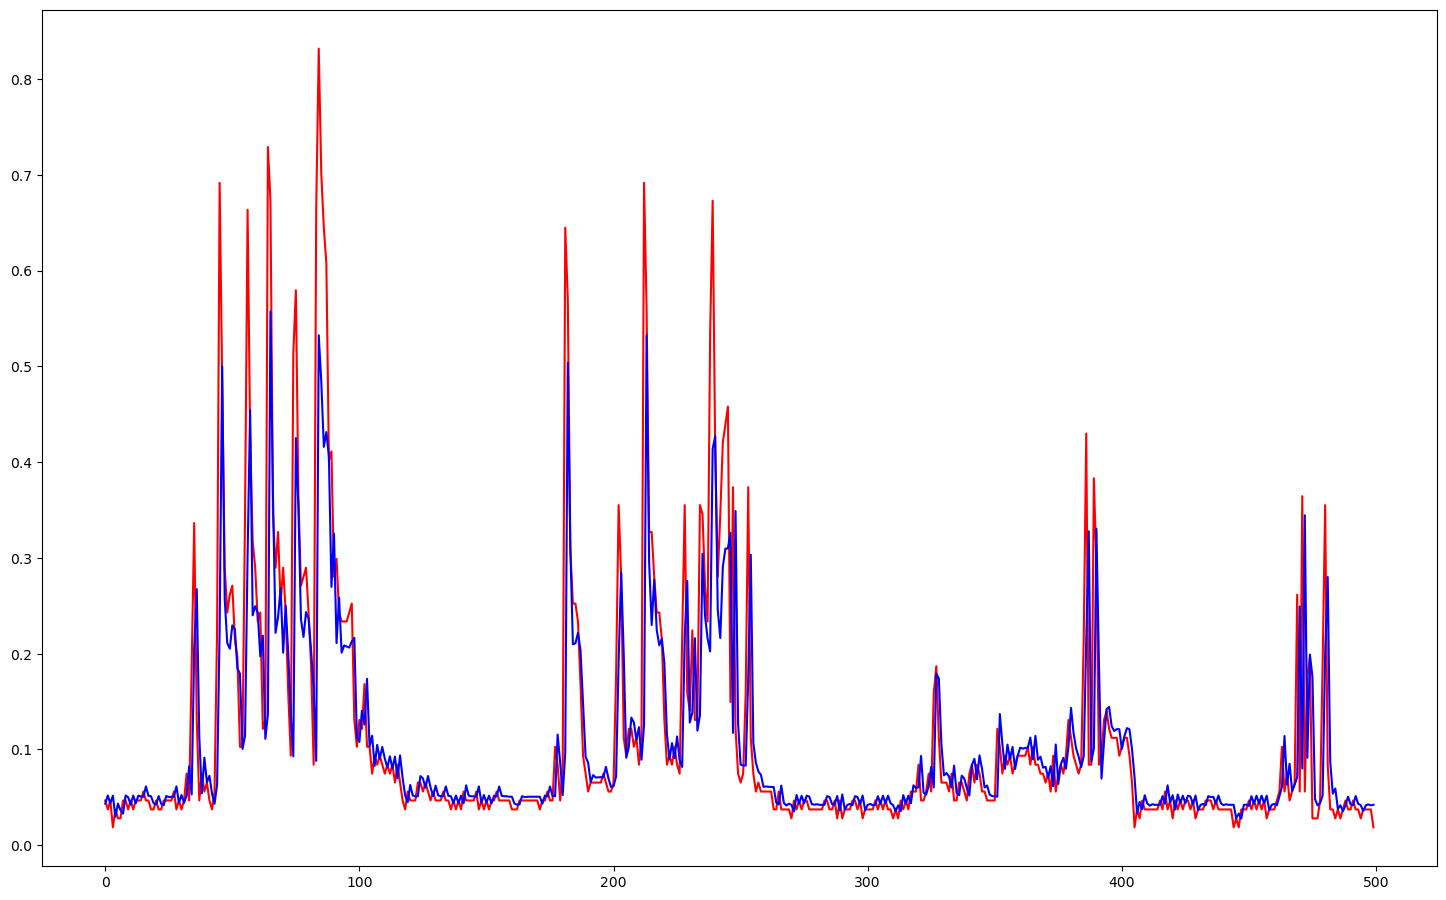

In [97]:
# There are many to plot since it's 
plt.figure(figsize=(18, 18 / 1.618)); 
plt.plot(y_test_w[:500], "r")
plt.plot(y_pred[:500], "b")